In [ ]:
from utils import add_noise, model_params, smooth, save_model, load_model, set_random_seed, TripletLoss, visualize_progress, display_projections, Trainer, UnNormalize

In [ ]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torchvision import models

from torch.utils.tensorboard import SummaryWriter

2.0.1+cu118


In [ ]:
#from utils import eval_model, train, smooth, save_model, load_model, model_params, eval_plots, set_random_seed, eval_model_conf

In [ ]:
# choose device to be used depending on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!cp /content/drive/MyDrive/Market-1501-v15.09.15.zip /content/data/

In [ ]:
!unzip -q -d data data/Market-1501-v15.09.15.zip

In [ ]:
from dataset_utils import Market1501, TripletDataset, TripletDatasetWrapper

In [ ]:
train_transforms = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.486, 0.459, 0.408), (0.229, 0.224, 0.225)),
            ])

test_transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.486, 0.459, 0.408), (0.229, 0.224, 0.225)),
                ])


pre_train_dataset = Market1501('/content/data/Market-1501-v15.09.15/bounding_box_train', transforms = train_transforms)
pre_test_dataset = Market1501('/content/data/Market-1501-v15.09.15/bounding_box_test', transforms = test_transforms)

### Define models for learning

In [ ]:
from model import AdpSiameseModel

model = AdpSiameseModel(emb_dim=512, pretrained = False, fine_tune = False)
model.to(device)

AdpSiameseModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
print(f"The generator has {model_params(model)} parameters.")

The generator has 11701824 parameters.


create dataset (depending on model)

In [ ]:
t_train_dataset = TripletDataset(pre_train_dataset)
test_dataset = TripletDataset(pre_test_dataset)
val_dataset = test_dataset#TripletDataset(pre_val_dataset)

# authors of paper for online mining used mini batch size of 'thousands'. here we use only 64 because of the
# increase in computation/training time. better results might be achieved with higher size
train_dataset = TripletDatasetWrapper(t_train_dataset, model = model, device = device, mini_batch_size = 64)
# only the trainin set uses data mining.

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 12936
Test samples: 19732
Validation samples: 19732


Some example images

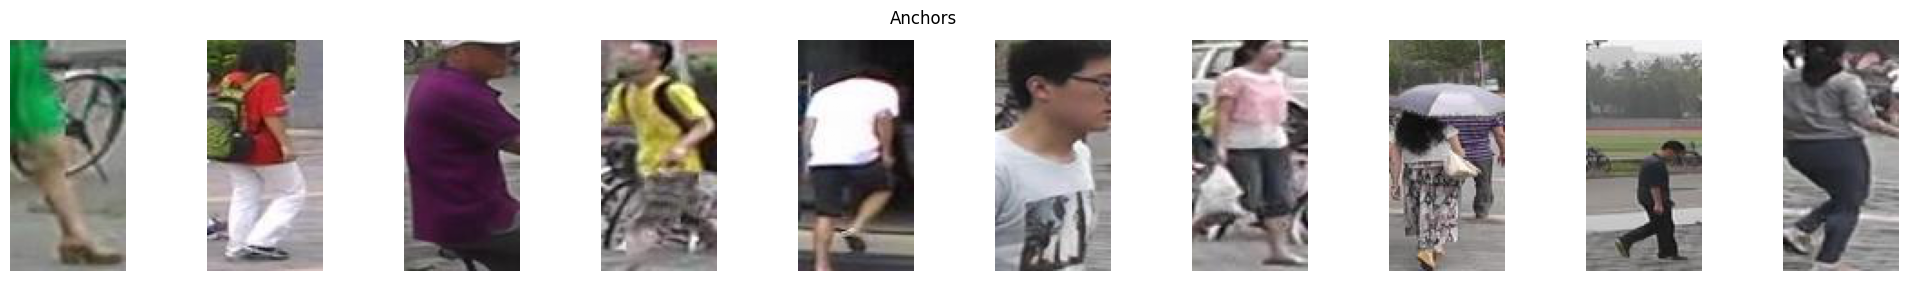

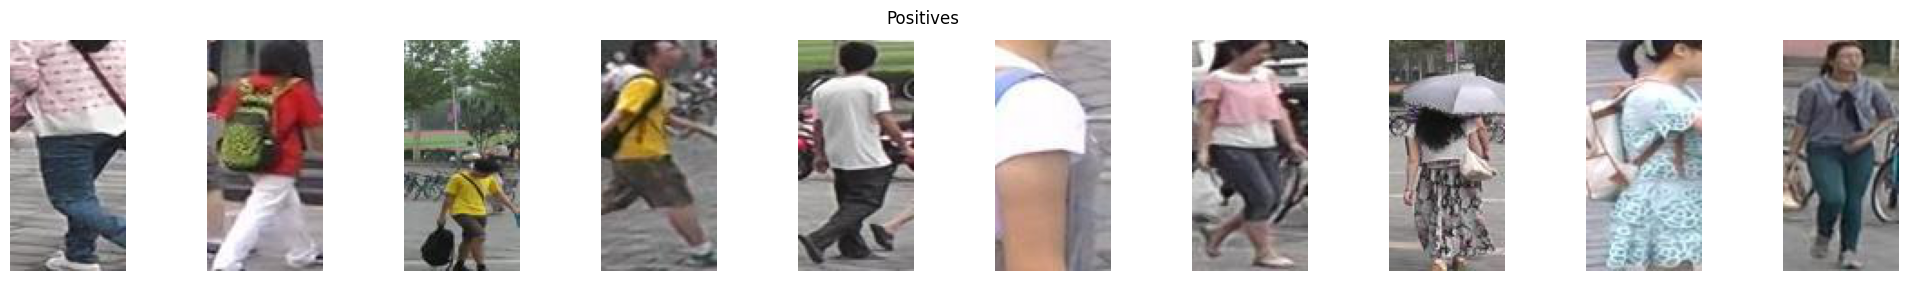

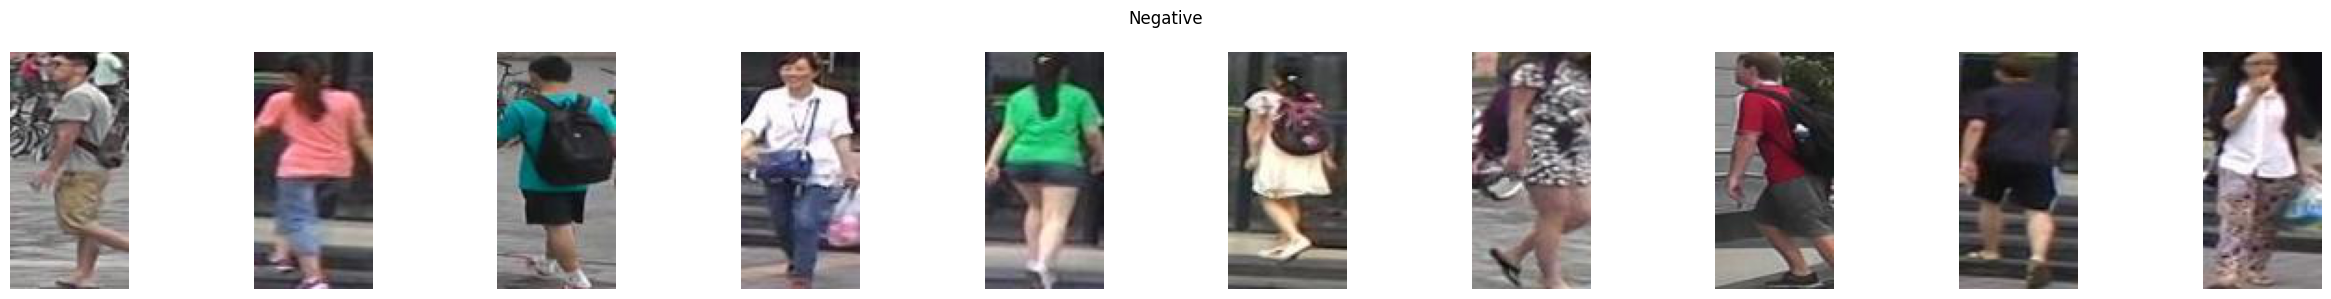

In [ ]:
fig_anchors, anchors = plt.subplots(1, 10, figsize=(25,3))
fig_pos, positives = plt.subplots(1, 10, figsize=(25,3))
fig_neg, negatives = plt.subplots(1, 10, figsize=(25,3))
for i in range(10):
    (anchor, positive, negative), _ = val_dataset[i+6]
    anchors[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(anchor).permute(1,2,0))
    anchors[i].axis("off")
    positives[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(positive).permute(1,2,0))
    positives[i].axis("off")
    negatives[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(negative).permute(1,2,0))
    negatives[i].axis("off")
fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negative")
plt.tight_layout()

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### definition of learning parameters

In [ ]:
criterion = TripletLoss(margin=0.2)

In [ ]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=valid_loader, n_iters=2200) # here only 2500 iterations as training with data mining is much slower (by about factor of 10)

In [ ]:
import time
set_random_seed(420)
start_time = time.time()
trainer.fit()
print("--- %s seconds ---" % (time.time() - start_time))

The training with online data mining takes much longer.

### some training stats

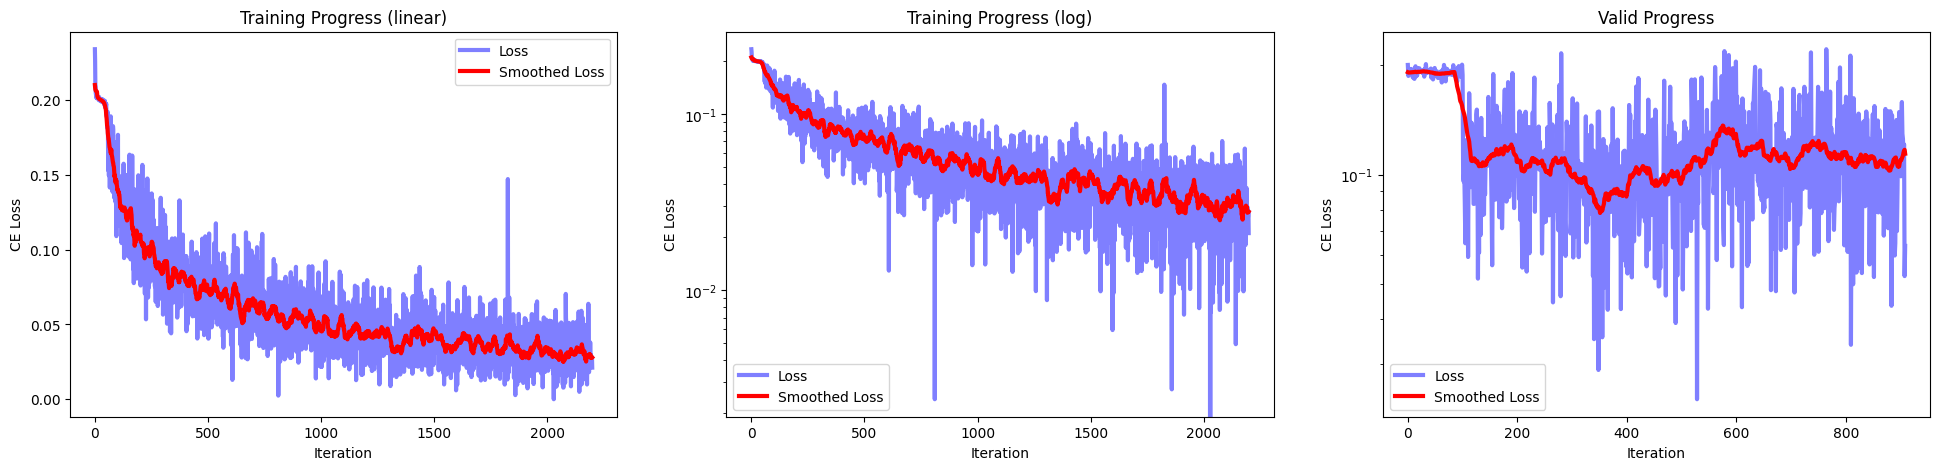

In [ ]:
visualize_progress(trainer.train_loss, trainer.valid_loss, start=0)

The training loss decreases steadily. It looks like is decreases faster compared to the model that does not use online data mining. The resulting loss is slightly higher. The validation loss decreases sharply in the beginning, and then stays (approximately) constant. The validaton loss result is about the same compared to the model trained without data mining.

### performance on full test set

In [ ]:
set_random_seed(42) # always use same random seed to ensure comparability between models
full_loss, pred, true_val = trainer.valid_step(val_iters=len(test_dataset), get_res = True)
print(f"The full loss on the test set is {full_loss[0]}.")

The full loss on the test set is 0.12388753890991211.


The overall loss on the training set is slightly lower compared to the model that does not use data mining (0.124 vs. 0.131). 

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(true_val, pred)

print(f"AUC = {auc}.")

AUC = 0.8520354125784191.


Here the result is also slightly better compared to the model that does not use data mining. (0.852 vs 0.838)

### embeddings

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
model = model.eval()

In [ ]:
(img,_,_),(lbl,_,_) = next(iter(test_loader))

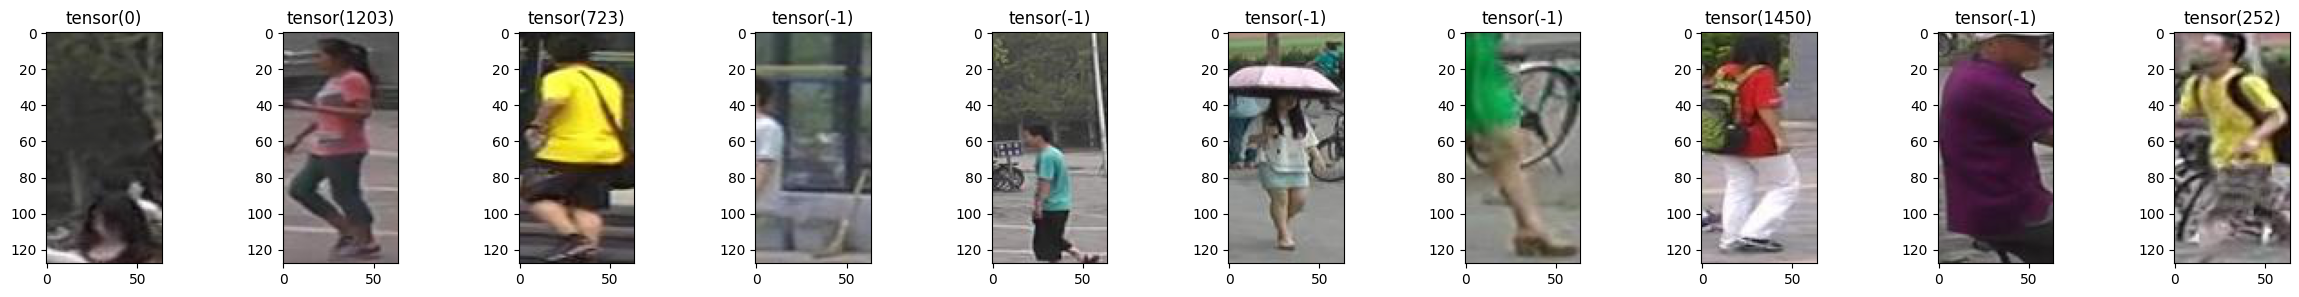

In [ ]:
fig, ax = plt.subplots(1,10, figsize=(30,3))
for i in range(10):
    ax[i].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(img[i]).permute(1,2,0))
    ax[i].set_title(lbl[i])

In [ ]:
embs = []
labels = []
with torch.no_grad():
    for (anchor, _, _), (lbl,_, _) in test_loader:
        anchor = anchor.to(device)
        anchor_emb = model.forward_one(anchor)

        labels.append(lbl)
        embs.append(anchor_emb.cpu())

labels = np.concatenate(labels)
embs = np.concatenate(embs)

In [ ]:
pca_embs = PCA(n_components=2).fit_transform(embs)

In [ ]:
k = 25   # use 25 'random' classes for diagrams (with more classes colors get mixed up)
labels_to_keep = list(np.unique(labels)[23:k+23]) # keep first n labels for plotting (+1 to not keep 'noise images')
N = 5000

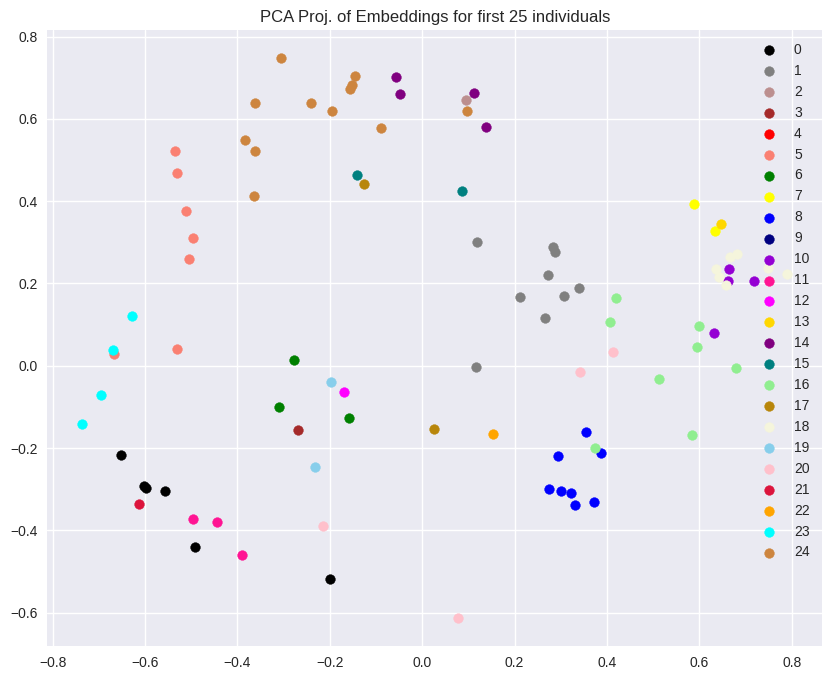

In [ ]:
plt.style.use('seaborn-v0_8')
fig,ax = plt.subplots(1,1,figsize=(10,8))
display_projections(pca_embs[:N], labels[:N], ax=ax, labels_to_keep = labels_to_keep)
ax.set_title(f"PCA Proj. of Embeddings for first {k} individuals")
plt.show()

The plot above shows some structure compared to the diagram from the model without data mining. Datapoints from the same class seem to be placed close to each other (mostly). However one can not clearly differentiate between clusters in most cases.

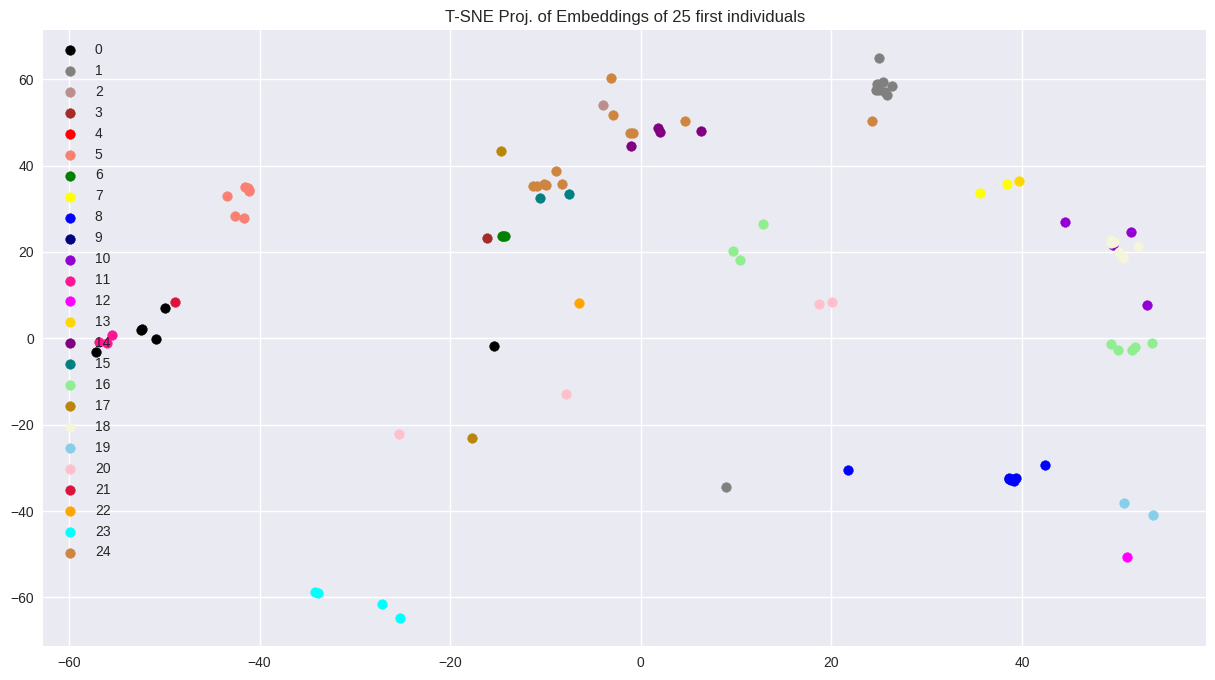

In [ ]:
tsne_embs = TSNE(n_components=2).fit_transform(embs[:N])

fig,ax = plt.subplots(1,1,figsize=(15,8))
display_projections(tsne_embs[:N], labels[:N], ax=ax, labels_to_keep = labels_to_keep)
ax.set_title(f"T-SNE Proj. of Embeddings of {k} first individuals")
plt.show()

The separation with tsne also shows some clustering of the different classes (with some errors). Clusters are also pulled appart. This result is also much better compared to the model without data mining.

### Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
kmeans_embs = KMeans(n_clusters=len(np.unique(labels[:2500])), random_state=0).fit(embs[:2500])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
ari_embs = adjusted_rand_score(labels[:2500], kmeans_embs.labels_)

In [ ]:
print(f"Clustering embeddings achieves ARI={round(ari_embs*100,2)}%")

Clustering embeddings achieves ARI=0.83%


some images

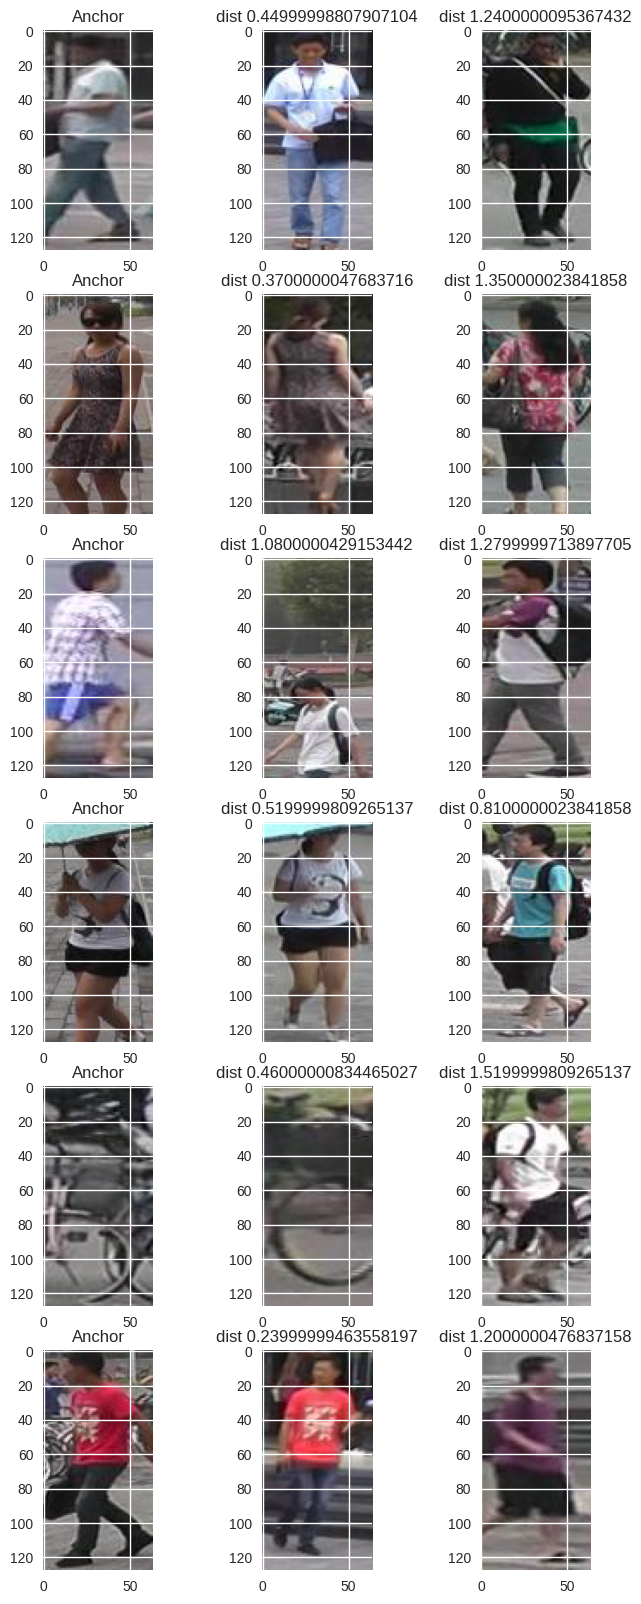

In [ ]:
n_img = 6

fig,ax = plt.subplots(n_img,3,figsize=(8,20))


for i in range(n_img):
  item, _ = test_dataset[i+345]

  embs = model(item[0].to(device).reshape(1,3,128,64), item[1].to(device).reshape(1,3,128,64), item[2].to(device).reshape(1,3,128,64))

  d_p = torch.sqrt((embs[0] - embs[1]).pow(2).sum(dim=-1)).detach().cpu().numpy()
  d_n = torch.sqrt((embs[0] - embs[2]).pow(2).sum(dim=-1)).detach().cpu().numpy()

  ax[i,0].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[0]).permute(1,2,0))
  ax[i,0].set_title('Anchor')
  ax[i,1].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[1]).permute(1,2,0))
  ax[i,1].set_title(f"dist {round(d_p[0],2)}")
  ax[i,2].imshow(UnNormalize(mean=(0.486, 0.459, 0.408), std=(0.229, 0.224, 0.225))(item[2]).permute(1,2,0))
  ax[i,2].set_title(f"dist {round(d_n[0],2)}")


In the images above are some images compared to images of the same individual and a random other individual with the distances compared to the anchor image. The calculated values seem to make sense, where persons that can be reidentified by a human (here us) have a much lower distance and individuals that look much better have a much bigger distance. The results seem te be similar to the results from the model without data mining. However with such a little amount of images it is hard to tell.

In conclusion we can say, that the data mining seems to improve the quality of the embedding space, which also improves the overall result slightly.